In [104]:
import sys
sys.path.append('..')

import myfcns
import model
import agents

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import rosen, differential_evolution, minimize, basinhopping, brute,fmin
from mpl_toolkits.mplot3d import Axes3D

import os
import sys
import time
import csv
import datetime
import math

import matplotlib.pyplot as plt
import seaborn as sns
from ptitprince import PtitPrince as pt


from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
'''
/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: 
The `IPython.html` package has been deprecated since IPython 4.0. 
You should import from `notebook` instead. 
`IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
'''

import random as rd
import math
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN


# setting
big = (12,12)
mid = (10,10)
small = (7,7)
height = 6  # for jointplot
sns.set(style="darkgrid")

In [2]:
# my fcn

def a2s(x):  # 呼び出すときは、np.fromstring(txt, sep=',')
    x = np.array(x).flatten()
    return np.array2string(x, precision=2, separator=',',suppress_small=True)[1:-1]
def plot4d(x,y,z,c,title=""):
    fig = plt.figure()
    ax1 = fig.add_subplot(projection='3d')
    c = c / min(c)
    sc = ax1.scatter(x,y,z,zdir='z', c=c, cmap=plt.cm.autumn.reversed())  #binary
    plt.colorbar(sc)
    plt.title(title)
    return

choice2idx = {"left":0, "middle":1, "right":2}
agent_names = ["AgentGreedyRandom", 
               "AgentSimpleRL", 
               "AgentDimensionRL", 
               "AgentRuleBasedSimpleRL0", 
               "AgentRuleBasedDimensionRL0",
               "AgentDimensionRLwithDecay",
               "AgentDimensionRLwithInfoBonus",
               "AgentDimensionRLwithDecaywithInfoBonusWithoutBeta"]

In [43]:
#plt.figure()
#sns.lineplot(log.log.sum_score, range(len(log.log.sum_score)))

def fitting(x = [.1, .8, .7], log_filename='log/01.csv', agent_name="AgentRuleBasedDimensionRL0", beta=5, get_ll_history=False):
    if(not (np.all(np.array([0,0,0,0]) <= x) and np.all(np.array([1.0, 1.0, 1.0, 30]) >= x))):
        return 10000
    
    #if(not (np.all(np.array([0,0,0,0]) <= x) and np.all(np.array([1.0,50,1.0,1.0]) >= x))):
    #    return 1000
    #alpha, beta, init_value = x
    #alpha, beta, init_value, decay = x  # dimRL with decay
    #alpha, beta, init_value, info_weight = x  # dimRL with info bonus
    alpha, init_value, decay, info_weight = x  # dimRL with info bonus
    #alpha, beta, init_value, epsilon = x
    game_filename = "rateTable_size20_300trials_0004.csv"
    log_filename = log_filename
    #g = model.Game(game_filename)
    log = model.GameFromLog(log_filename)
    a1 = eval("agents."+ agent_name + "(alpha=alpha, init_value=init_value, decay=decay, info_weight=info_weight, beta=beta)") # 2, 3
    m = model.Memory(log_filename,agent_name)
    
    choice2idx = {"left":0, "middle":1, "right":2}
    
    #以下を繰り返す
    sum_of_log_likelihood = 0
    likelihoods = []
    for i in range(300): # 300も変更した方が良いと思う。
        #optionをlogから取得
        ops = log.get_options()
        #choice rateを取得
        choice_probs = a1.get_choice_probs(ops)
        #choice logを取得
        choice = log.get_choice()
        
        #choice logとchoice probのdiffを取る　→ likelihood
        #likelihood = np.log(1 - choice_probs[choice2idx[choice]]/100.0 + 1e-6)  <-間違っていた式
        likelihood = np.log(choice_probs[choice2idx[choice]]/100.0 + 1e-6)
        likelihoods.append(likelihood)
        sum_of_log_likelihood += likelihood
        #update value table
        vt = a1.update(log.get_option_chosen(), log.get_hit_or_blow())
        m.save_value_table(vt)
        log.to_next_trial()
    print("\r{}: {}".format(x, sum_of_log_likelihood), end="")
    if(get_ll_history):
        return [m.value_table, likelihoods, sum_of_log_likelihood]
    return -sum_of_log_likelihood #maximizeするので、正負逆転させる
    
#end fitting()

def fittings(x = [.1, .8, .7], log_filename="log/01.csv",agent_name="AgentRuleBasedDimensionRL0", beta=5):
    sums = []
    ll_history = []
    for i in range(1):
        sums.append(fitting(x,agent_name=agent_name, log_filename=log_filename, beta=beta))
    return np.mean(sums)

#fitting()
x0 = [.1, .8, .7]
class MyBounds():
    def __init__(self, xmin=[0,0,0], xmax=[1,10,1]):
        self.xmin = np.array(xmin)
        self.xmax = np.array(xmax)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin
    def plot(self, res, i=0, j=1, seq=.2):
        x = np.arange(self.xmin[i],self.xmax[i], seq)
        y = np.arange(self.xmin[j],self.xmax[j], seq)
        xx, yy = np.meshgrid(x, y, sparse=True)
        z = (1.5-xx+xx*yy)**2+(2.25-xx+xx*yy**2)**2+(2.625-xx+xx*yy**3)**2
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_wireframe(xx, yy, z)
        ax.scatter(res.x[i], res.x[j], res.fun, s=100, c="r")
        return

def fit_all(test=False, agent_name = "AgentRuleBasedDimensionRL0", beta=.5):
    print(agent_name)
    files = myfcns.get_file_name("log")
    if(test):
        files = [files[0]]
    agent_name = agent_name
    fit_fcn = "brute"
    results = []
    columns = ["log_filename", "agent_name", "Fit_function", "xranges", "x0", "LL","x","y","z","LL_grid"]
    with open("fit_table_"+agent_name+"_"+fit_fcn+'.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(columns)
    for file in files:
        print(file)
        #xranges = (slice(0,1,0.02), slice(0,6,0.25), slice(0,1,0.05))
        #xranges = (slice(.1,.95,.05), slice(0,6.5,0.5), slice(0,1,0.1))
        #xranges = (slice(.04,.15,.04), slice(0,0.75,0.25), slice(0.2, 2, .4), slice(.8,17,4))
        #res = brute(fittings, xranges, disp=True,full_output=True,args=(file, agent_name))#('log_filename',file),('agent_name', agent_name)))
        x0 = [.05, .1, .2, 7]
        kwargs = {'args':(file,agent_name, beta)}
        res = basinhopping(fittings, x0,disp=True, minimizer_kwargs=kwargs)
        #print(res)
        print("    ")
        print("========================================")
        #print("    ")
        #x = a2s(res[2][0])
        #y = a2s(res[2][1])
        #z = a2s(res[2][2])
        #ll = a2s(res[3])
        new_row = np.array([file, agent_name, fit_fcn, "{}".format(xranges),a2s(-res[0]), res[1], x,y,z,ll]) #LLの正負を戻す
        results.append(new_row)
        with open("fit_table_"+agent_name+"_"+fit_fcn+'.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(new_row)
        #pd.DataFrame(new_row.reshape(1,len(columns)), columns = columns).to_csv(agent_name+"_"+fit_fcn+"_"+file[4:]+".csv")
        #MyBounds().plot(res)
    return results

In [35]:
#results = []
#for agent_name in agent_names:
#    results.append(fit_all(agent_name=agent_name))
#a = fitting(x = [ 0.05,12.2 , 0.33, 0.1], log_filename='log/01.csv', agent_name="AgentDimensionRLwithInfoBonus", get_ll_history=True)

results = fit_all(agent_name="AgentDimensionRLwithDecaywithInfoBonusWithoutBeta", beta=.5)

"""
kwargs = {"args": "log/hiratas_test20191123.csv"}  
res1 = basinhopping(fittings, x0, accept_test=MyBounds(),niter=5,disp=True,niter_success=10, minimizer_kwargs=kwargs)
print(res1)

kwargs = {"args": "log/chenQixiang_test20191201.csv"}
res2 = basinhopping(fittings, x0, accept_test=MyBounds(),niter=5,disp=True,niter_success=10, minimizer_kwargs=kwargs)
print([res1,res2])
"""


AgentDimensionRLwithDecaywithInfoBonusWithoutBeta
log/01.csv


TypeError: minimize() got an unexpected keyword argument 'log_filename'

/Users/arataNonami/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


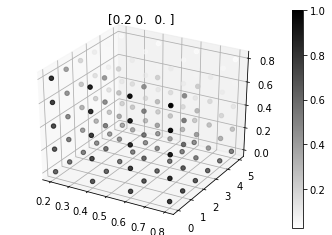

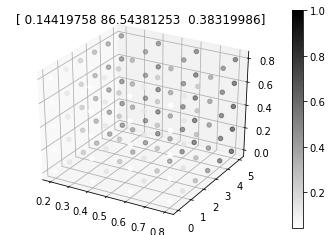

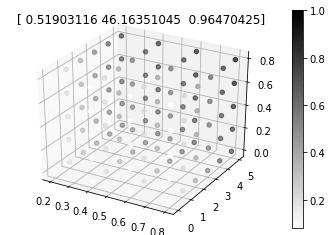

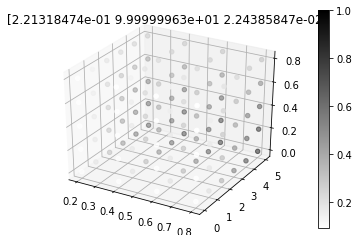

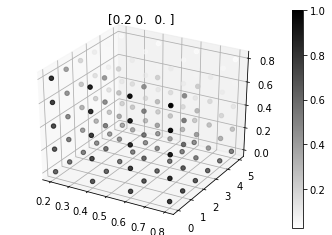

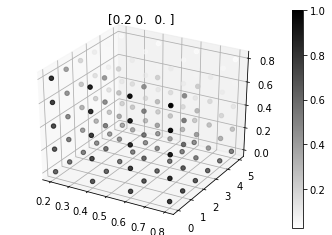

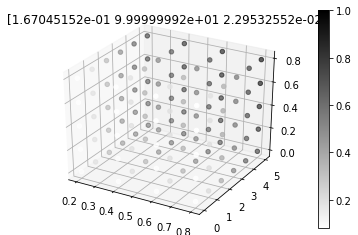

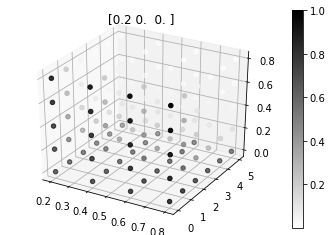

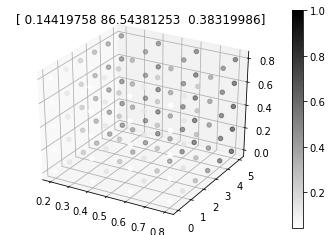

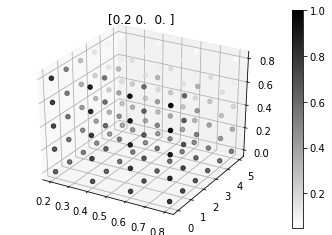

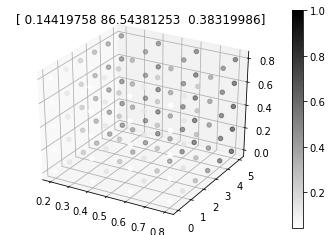

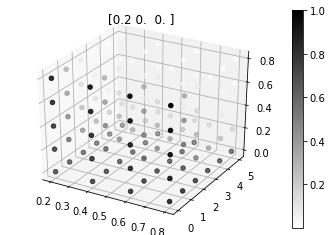

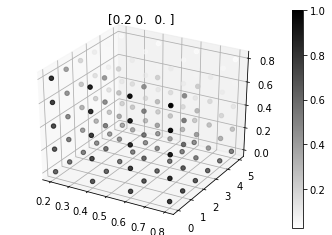

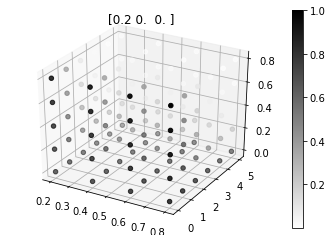

In [7]:
files = myfcns.get_file_name("log")
#xranges = (slice(.1,1.0,.1), slice(0,6,1), slice(0,1,0.1))

for res in results_dimRL:
    ll = np.array(res[3]).flatten()
    c =  ll j/ min(ll)
    fig = plt.figure()
    ax1 = fig.add_subplot(projection='3d')
    sc = ax1.scatter(res[2][0], res[2][1], res[2][2],zdir='z', c=c, cmap=plt.cm.binary) 
    plt.colorbar(sc)
    plt.title(res[0])


In [4]:
files = myfcns.get_file_name("log")

print("")
#print(likelihoods)
#myfcns.get_average_change(data=likelihoods, span=5, if_plot=True)
def f(file, span):
    x = [0,0,0 ]
    likelihoods, sum_of_log_likelihood, opss = fitting(x = x, log_filename=file, get_ll_history=True)
    print("")
    print(opss)
    #sns.lineplot(opss)
    #myfcns.get_average_change(data=likelihoods, span=span, if_plot=True)
interact(f, file=files,span=widgets.IntSlider(min=1,max=30,step=1,value=5))


interactive(children=(Dropdown(description='file', options=('log/chenQixiang_test20191201.csv', 'log/hiratas_t…

<function __main__.f(file, span)>

-121.64, -121.64, -121.64, -121.64, -121.64, -121.64, -121.64, -121.64,
  -121.64, -121.64, -121.64, -121.64, -908.45, -841.94, -775.35,-1722.29,
 -1614.58,-1486.33,-2074.03,-1986.79,-1848.7 ,-2240.66,-2163.56,-2038.59,
 -1212.96,-1166.26,-1120.45,-1821.29,-1753.89,-1658.49,-1829.95,-1830.72,
 -1709.24,-1832.44,-1836.91,-1758.8


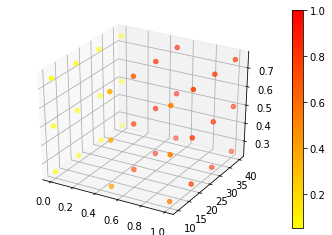

In [65]:
print(a2s(np.array(results_dimRL[1][3]).flatten())[2:-2])
x = np.array(results_dimRL[1][2][0]).flatten()
y = np.array(results_dimRL[1][2][1]).flatten()
z = np.array(results_dimRL[1][2][2]).flatten()
c = np.array(results_dimRL[1][3]).flatten()
plot4d(x,y,z,c)

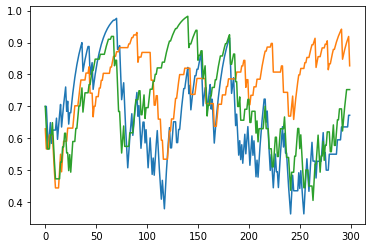

In [16]:

plt.plot(a)

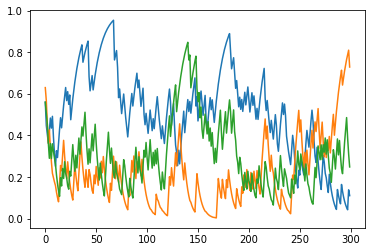

In [22]:
plt.plot(a)

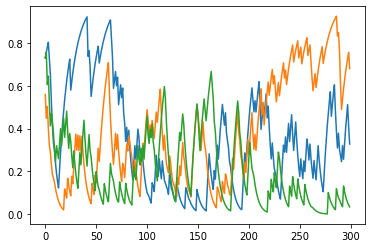

In [24]:
plt.plot(a)

In [11]:
x = np.arange(0,1,0.01)
f = lambda x: -x*np.log2(x)
f(x)+f(1-x)

def sigmoid(self, vals):
    #print("\r{}: {}".format(vals, self.beta * vals), end="")
    a = np.array(self.beta * vals)
    ex = np.exp(a)
    below = sum(ex)/100.0
    return ex/below


array([1.76670891e+220, 9.67254450e+201, 4.61537058e+109])

In [ ]:
x = np.array([500.332, 321.324, 354.1234])
def f(x):
    x = x + (x==np.zeros(len(x)))*1e-5 - (x==np.ones(len(x)))*1e-5
    f = lambda x: -x*np.log2(x)
    return f(x)+f(1-x)
plt.plot(x,f(x))

[0.33, 4.68, 0.62, 0.18]: -179.29764225805908

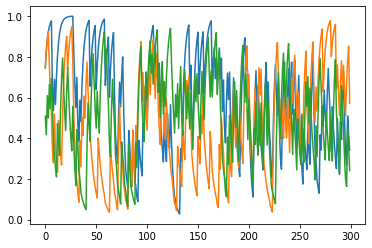

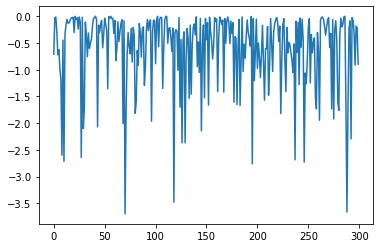

In [27]:
a = fitting(x = [0.33,4.68,0.62,0.18], log_filename='log/04.csv', agent_name="AgentDimensionRLwithInfoBonus", get_ll_history=True)
plt.plot(a[0])
plt.figure()
plt.plot(a[1])

# betaとinfo相関を調べる
## beta = 6の時

0.9286948917621214 5.804081001256905e-07
0.264348921612742 0.341053989677151
0.9487798812673348 7.097743591191951e-08
0.8066890095846344 0.00027915487680802033


<Figure size 432x288 with 0 Axes>

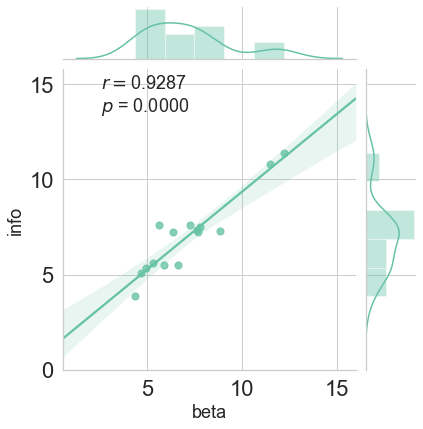

<Figure size 432x288 with 0 Axes>

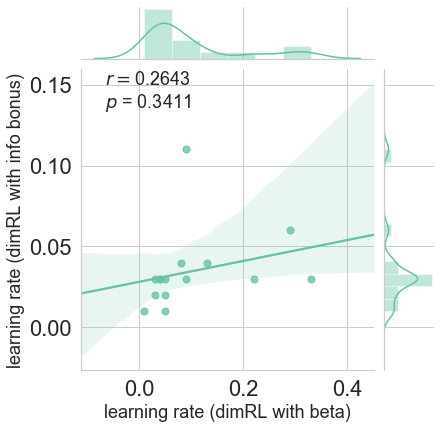

<Figure size 432x288 with 0 Axes>

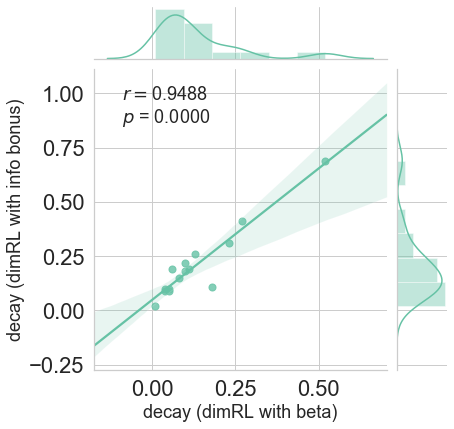

<Figure size 432x288 with 0 Axes>

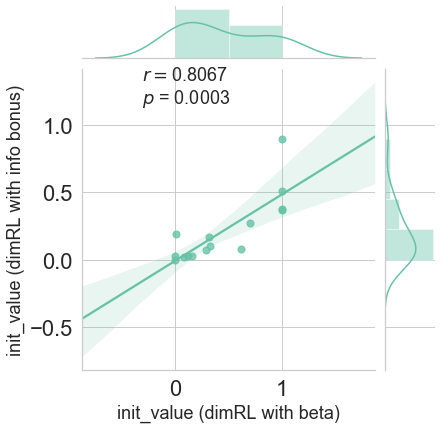

In [158]:
def corr(x,y,title="", xlabel="", ylabel=""):
    r, p = stats.pearsonr(x, y)
    print(r, p)
    plt.figure()
    sns.set_palette("Set2")
    sns.jointplot(x, y, kind="reg", height=6,scatter_kws={'s':50})
    
    plt.rcParams["font.size"] = 18
    plt.text(min(x)-np.std(x)*.8, max(y)+np.std(y)*1.1,'$\it{r}= $'+'{:.4f}\n'.format(r) + '$\it{p}$ = '+'{:.4f}'.format(p))
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title)
    return

beta = [12.2, 5.63, 5.89, 4.68, 4.33,7.59, 5.3,6.37,7.78,7.65,8.84, 7.26, 4.93, 11.44,6.6]
info = [11.4, 7.61,5.5, 5.11, 3.87, 7.37, 5.6, 7.26, 7.49,7.25,7.28, 7.6, 5.34, 10.79, 5.5]
corr(beta,info, xlabel="beta", ylabel="info")

alpha_beta = [.05, .22,.03,.33,.09,.08,.13,.05,.04,.09,.01,.05,.29,.03,.04]
alpha_info = [.03,.03,.03,.03,.11,.04,.04,.01,.03,.03,.01,.02,.06,.02,.03]
corr(alpha_beta, alpha_info, xlabel="learning rate (dimRL with beta)", ylabel="learning rate (dimRL with info bonus)")

decay_beta = [.1,.52,.04,.18,.06,.1,.13,.27,.04,.11,.01,.05,.23,.05,.08]
decay_info = [.22,.69,.1,.11,.19,.18,.26,.41,.09,.19,.02,.1,.31,.09,.15]
corr(decay_beta, decay_info, xlabel="decay (dimRL with beta)", ylabel="decay (dimRL with info bonus)")

initv_beta = [.33,0,1,.62,.01,1,1,0,1,.29,.12,.16,.32,.08,.7]
initv_info = [.1,.03,.38,.08,.19,.37,.9,0,.51,.07,.03,.03,.17,.02,.27]
corr(initv_beta, initv_info, xlabel="init_value (dimRL with beta)", ylabel="init_value (dimRL with info bonus)")

## FitのLLをグラフにまとめる

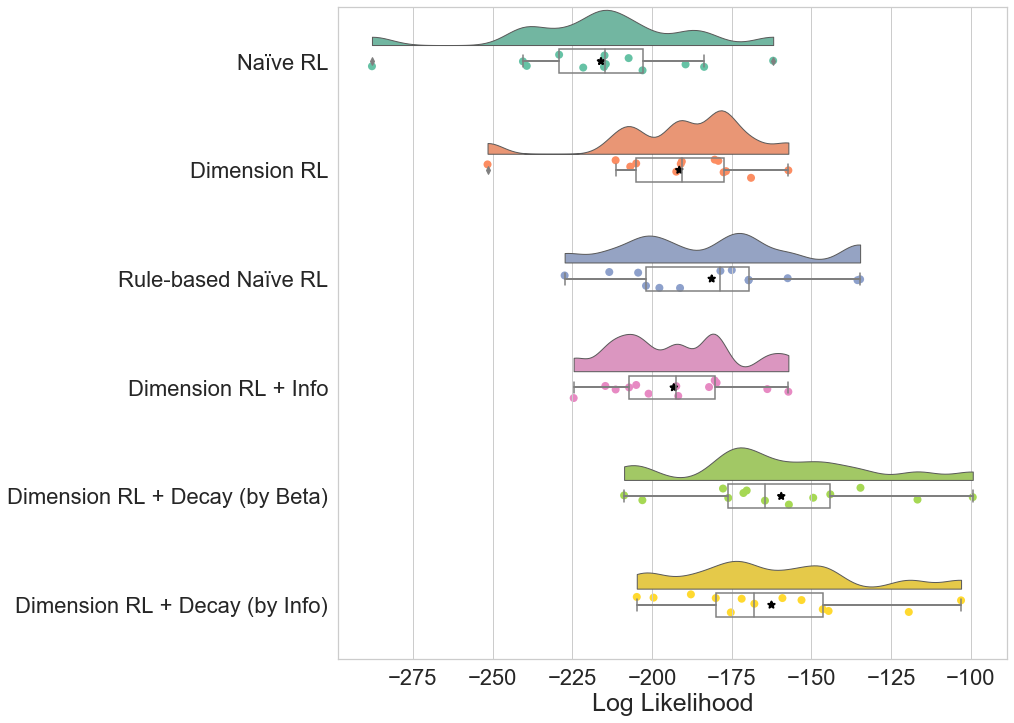

In [169]:
df = pd.read_csv('LL.csv')
sns.set(style="whitegrid",font_scale=2)
plt.figure(figsize=big)
#pt.RainCloud(data=df,orient='h')
plt.xlabel("Log Likelihood", fontsize=25)

#dx="Sensitivity"; dy="EmotionCondition"; 
ort="h"
ax=pt.half_violinplot(data=df, palette="Set2", bw=.2,  linewidth=1,cut=0.,
                   scale="area", width=.8, inner=None,orient=ort)
ax=sns.stripplot(data=df, palette="Set2", edgecolor="white",size=8,orient=ort,jitter=1,zorder=0)
ax=sns.boxplot(data=df, color="lightgray",orient=ort,width=.22,zorder=10,showcaps=True,boxprops={'facecolor':'none', "zorder":10},
               showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1)

sns.pointplot(data=df, color="black", markers='*',size=8, orient=ort, ci=None,join=None)

In [53]:
files = myfcns.get_file_name("log")
agent_name="AgentDimensionRLwithDecaywithInfoBonusWithoutBeta"
beta=.5
x0 = [.05, .1, .2, 7]
kwargs = {'args':(files[0],agent_name, beta)}
res = basinhopping(fittings, x0, disp=False,minimizer_kwargs=kwargs)

[ 0.04019311  0.19575413  0.47913762 10.94420946]: -121.89563479024181381942222197

KeyboardInterrupt: 